# House Price V2

Follow this reference: Stacked Regressions : Top 4\% on LeaderBoard:

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [2]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


#pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output

In [4]:
ls data

sample_submission.csv       submission_xgb.csv
submission_baseline.csv     test.csv
submission_lightgbm_v1.csv  train.csv
submission_rf_v2.csv


In [6]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [9]:
pd.set_option('display.max_columns', None)
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [10]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


In [11]:
#Save the 'Id' column
train_id = train['Id']
test_id = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## Data Processing

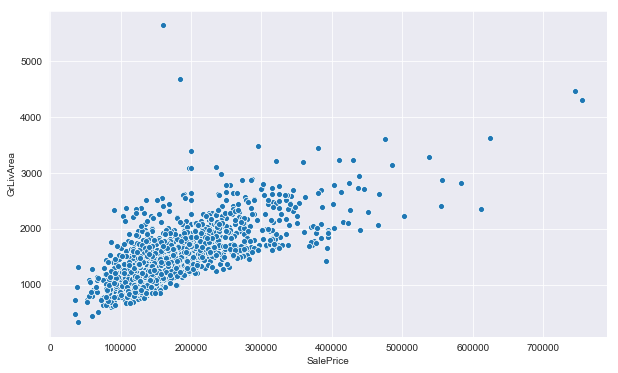

In [14]:
plt.figure(figsize = (10, 6))
sns.scatterplot(x="SalePrice", y="GrLivArea", data=train)
plt.show()

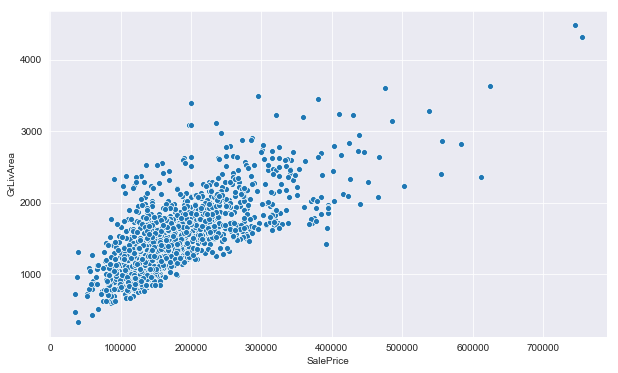

In [16]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

plt.figure(figsize = (10, 6))
sns.scatterplot(x="SalePrice", y="GrLivArea", data=train)
plt.show()

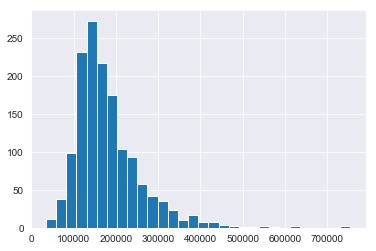

In [20]:
train.SalePrice.hist(bins=30)


 mu = 180932.92 and sigma = 79467.79



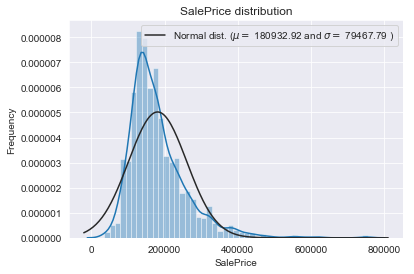

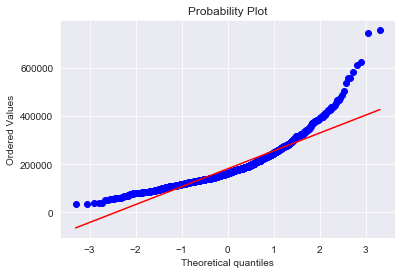

In [21]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



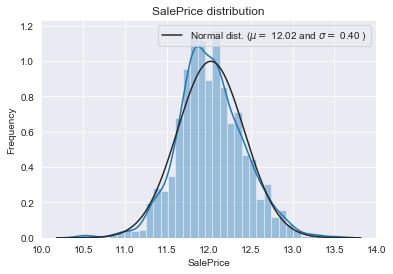

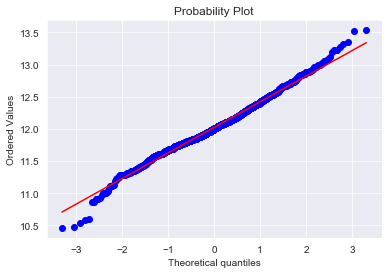

In [23]:
# Log-transformation of the target variable

train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

## Missing Values

In [51]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [52]:
fields = list(all_data.columns)
missing = list(all_data.isnull().sum())

df_missing = pd.DataFrame({'field':fields, "missing":missing}).sort_values('missing',ascending=False)
df_missing['rate'] = df_missing.missing/all_data.shape[0]
df_missing[df_missing.rate>0]

,field,missing,rate
65,PoolQC,2908,0.996915
56,MiscFeature,2812,0.964004
3,Alley,2719,0.932122
25,Fence,2346,0.804251
26,FireplaceQu,1420,0.486802
49,LotFrontage,486,0.166610
37,GarageYrBlt,159,0.054508
35,GarageQual,159,0.054508
34,GarageFinish,159,0.054508
33,GarageCond,159,0.054508


In [53]:
# PoolQC

all_data['PoolQC'] = all_data["PoolQC"].fillna("None")

In [54]:
all_data['PoolQC'].value_counts()

None    2908
Ex         4
Gd         3
Fa         2
Name: PoolQC, dtype: int64

In [55]:
# MiscFeature

all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

In [56]:
# Alley

all_data["Alley"] = all_data["Alley"].fillna("None")

In [57]:
# Fence

all_data["Fence"] = all_data["Fence"].fillna("None")

In [58]:
# FireplaceQu

all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [59]:
# LotFrontage

all_data['LotFrontage'] = all_data.groupby("Neighborhood")["LotFrontage"]\
                         .transform(lambda x: x.fillna(x.median()))

In [61]:
all_data[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']]

,GarageType,GarageFinish,GarageQual,GarageCond
0,Attchd,RFn,TA,TA
1,Attchd,RFn,TA,TA
2,Attchd,RFn,TA,TA
3,Detchd,Unf,TA,TA
4,Attchd,RFn,TA,TA
5,Attchd,Unf,TA,TA
6,Attchd,RFn,TA,TA
7,Attchd,RFn,TA,TA
8,Detchd,Unf,Fa,TA
9,Attchd,RFn,Gd,TA


In [62]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [63]:
all_data[['GarageYrBlt', 'GarageArea', 'GarageCars']].head()

,GarageYrBlt,GarageArea,GarageCars
0,2003.0,548.0,2.0
1,1976.0,460.0,2.0
2,2001.0,608.0,2.0
3,1998.0,642.0,3.0
4,2000.0,836.0,3.0


In [64]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [66]:
all_data[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']].head(10)

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,706.0,0.0,150.0,856.0,1.0,0.0
1,978.0,0.0,284.0,1262.0,0.0,1.0
2,486.0,0.0,434.0,920.0,1.0,0.0
3,216.0,0.0,540.0,756.0,1.0,0.0
4,655.0,0.0,490.0,1145.0,1.0,0.0
5,732.0,0.0,64.0,796.0,1.0,0.0
6,1369.0,0.0,317.0,1686.0,1.0,0.0
7,859.0,32.0,216.0,1107.0,1.0,0.0
8,0.0,0.0,952.0,952.0,0.0,0.0
9,851.0,0.0,140.0,991.0,1.0,0.0


In [67]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [94]:
all_data[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,Gd,TA,No,GLQ,Unf
1,Gd,TA,Gd,ALQ,Unf
2,Gd,TA,Mn,GLQ,Unf
3,TA,Gd,No,ALQ,Unf
4,Gd,TA,Av,GLQ,Unf


In [95]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [70]:
# MasVnrArea and MasVnrType

all_data[['MasVnrArea','MasVnrType']].head()

,MasVnrArea,MasVnrType
0,196.0,BrkFace
1,0.0,None
2,162.0,BrkFace
3,0.0,None
4,350.0,BrkFace


In [71]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [80]:
all_data.MSZoning.isnull().sum()

4

In [81]:
all_data["MSZoning"] = all_data["MSZoning"].fillna(all_data['MSZoning'].mode()[0])

In [84]:
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [85]:
all_data = all_data.drop('Utilities',axis=1)

In [89]:
all_data["Functional"] = all_data["Functional"].fillna('Typ')

In [91]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [92]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [96]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [97]:
all_data.dtypes.value_counts()

object     42
int64      25
float64    11
dtype: int64

In [100]:
all_data.select_dtypes('float').columns

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF',
       'GarageArea', 'GarageCars', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea',
       'TotalBsmtSF'],
      dtype='object')

In [101]:
all_data.select_dtypes('int').columns

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'EnclosedPorch',
       'Fireplaces', 'FullBath', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
       'LotArea', 'LowQualFinSF', 'MSSubClass', 'MiscVal', 'MoSold',
       'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch',
       'TotRmsAbvGrd', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold'],
      dtype='object')

In [102]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [105]:
all_data.select_dtypes('object').columns

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature',
       'MoSold', 'Neighborhood', 'OverallCond', 'PavedDrive', 'PoolQC',
       'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street',
       'YrSold'],
      dtype='object')

In [106]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [108]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## Skewed features

In [109]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF',
       'CentralAir', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Fence',
       'FireplaceQu', 'Fireplaces', 'FullBath', 'Functional', 'GarageArea',
       'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageYrBlt',
       'GrLivArea', 'HalfBath', 'HeatingQC', 'KitchenAbvGr', 'KitchenQual',
       'LandSlope', 'LotArea', 'LotFrontage', 'LotShape', 'LowQualFinSF',
       'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF',
       'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC',
       'ScreenPorch', 'Street', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF',
       'YearBuilt', 'YearRemodAdd', 'YrSold', 'TotalSF'],
      dtype='object')

In [110]:
all_data[numeric_feats].apply(lambda x: skew(x.dropna()))

1stFlrSF          1.257286
2ndFlrSF          0.861556
3SsnPorch        11.372080
Alley            -0.651705
BedroomAbvGr      0.326568
BsmtCond         -2.861271
BsmtExposure     -1.117321
BsmtFinSF1        0.980645
BsmtFinSF2        4.144503
BsmtFinType1      0.083641
BsmtFinType2     -3.042979
BsmtFullBath      0.622415
BsmtHalfBath      3.929996
BsmtQual         -0.488362
BsmtUnfSF         0.919688
CentralAir       -3.457555
EnclosedPorch     4.002344
ExterCond        -2.496489
ExterQual        -1.800062
Fence            -1.992649
FireplaceQu       0.332611
Fireplaces        0.725278
FullBath          0.165514
Functional       -4.054126
GarageArea        0.216857
GarageCars       -0.219297
GarageCond       -3.594290
GarageFinish     -0.609953
GarageQual       -3.072788
GarageYrBlt      -3.904632
GrLivArea         1.068750
HalfBath          0.696666
HeatingQC         0.485534
KitchenAbvGr      4.300550
KitchenQual      -1.449814
LandSlope         4.973254
LotArea          13.109495
L

In [112]:
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})


Skew in numerical features: 



In [113]:
skewness

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [114]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

There are 59 skewed numerical features to Box Cox transform


In [115]:
skewness

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [116]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    print(feat)
    all_data[feat] = boxcox1p(all_data[feat], lam)

MiscVal
PoolArea
LotArea
LowQualFinSF
3SsnPorch
LandSlope
KitchenAbvGr
BsmtFinSF2
EnclosedPorch
ScreenPorch
BsmtHalfBath
MasVnrArea
OpenPorchSF
WoodDeckSF
1stFlrSF
LotFrontage
GrLivArea
TotalSF
BsmtFinSF1
BsmtUnfSF
2ndFlrSF
TotRmsAbvGrd
Fireplaces
HalfBath
TotalBsmtSF
BsmtFullBath
OverallCond
HeatingQC
FireplaceQu
BedroomAbvGr
GarageArea
OverallQual
FullBath
MSSubClass
YrSold
BsmtFinType1
GarageCars
YearRemodAdd
BsmtQual
YearBuilt
GarageFinish
LotShape
MoSold
Alley
BsmtExposure
KitchenQual
ExterQual
Fence
ExterCond
BsmtCond
PavedDrive
BsmtFinType2
GarageQual
CentralAir
GarageCond
GarageYrBlt
Functional
Street
PoolQC


## Getting dummy categorical features

In [117]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [118]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modeling

In [119]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [120]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Base models

In [121]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [122]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [123]:
# Kernel Ridge Regression

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [124]:
# Gradient Boosting Regression

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [125]:
# XGBoost

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [126]:
# LightGBM :

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [127]:
rmsle_cv(lasso)

array([0.10391486, 0.11461855, 0.12421441, 0.10529734, 0.10967492])

In [128]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [129]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [130]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [131]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)



In [132]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1151 (0.0072)



## Averaged base models class

In [133]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   